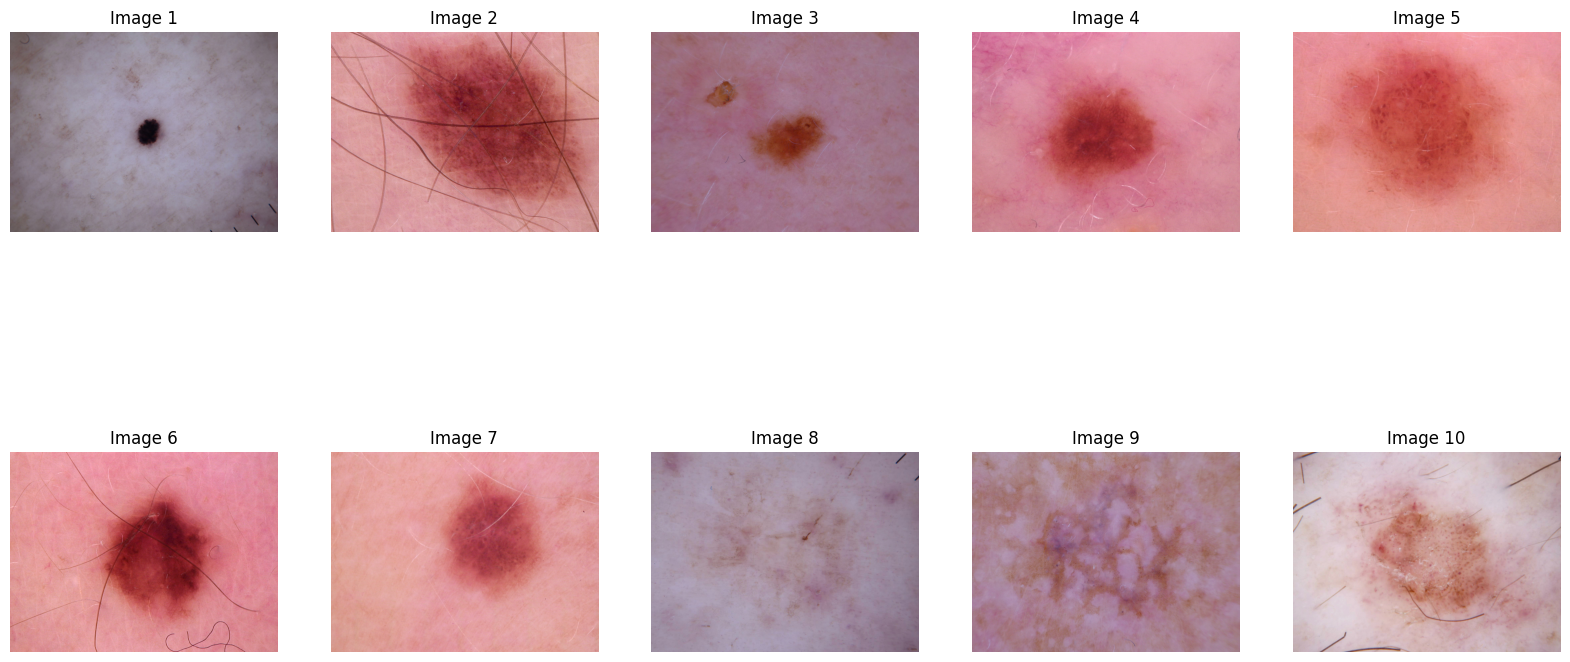

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.utils import make_grid
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import random
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import wandb




image_files = []
for dirname, _, filenames in os.walk('/kaggle/input/assignment-4/Assignment_4/Train/Train_data'):
    for filename in filenames:
        image_files.append(os.path.join(dirname, filename))

num_images_to_display = 10
plt.figure(figsize=(20, 10))

for i, image_file in enumerate(image_files[:num_images_to_display]):
    img = mpimg.imread(image_file)
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Image {i+1}')
    plt.axis('off')

plt.show()


In [ ]:
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 70

lr = 0.0002
decay = 0.0001
wandb_api = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
num_embeddings = 32

In [ ]:
wandb.login(key=wandb_api)

wandb: Currently logged in as: dipan009. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
train_dir = '/kaggle/input/assignment-4/Assignment_4/Train/Train_data'
test_dir = '/kaggle/input/assignment-4/Assignment_4/Test/Test_data'

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_filenames = [
            os.path.join(dp, f) for dp, dn, filenames in os.walk(image_dir)
            for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg']
        ]
        self.resize_transform = transforms.Resize((256, 256))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))
        self.horizontal_flip = transforms.RandomHorizontalFlip(p=1)
        self.vertical_flip = transforms.RandomVerticalFlip(p=1)
        self.rotation = transforms.RandomRotation(20)
        self.color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = self.image_filenames[idx]
        image = Image.open(image_path).convert('RGB')

        resized_image = self.resize_transform(image)
        tensor_image = self.to_tensor(resized_image)
        normalized_image = self.normalize(tensor_image)

        flipped_horizontally = self.normalize(self.to_tensor(self.horizontal_flip(resized_image)))
        flipped_vertically = self.normalize(self.to_tensor(self.vertical_flip(resized_image)))
        rotated = self.normalize(self.to_tensor(self.rotation(resized_image)))
        color_adjusted = self.normalize(self.to_tensor(self.color_jitter(resized_image)))

        transformed_images = [normalized_image, flipped_horizontally, flipped_vertically, rotated, color_adjusted]
        selected_image = random.choice(transformed_images)

        return selected_image


In [ ]:
train_dataset = CustomDataset(train_dir)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(test_dir)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

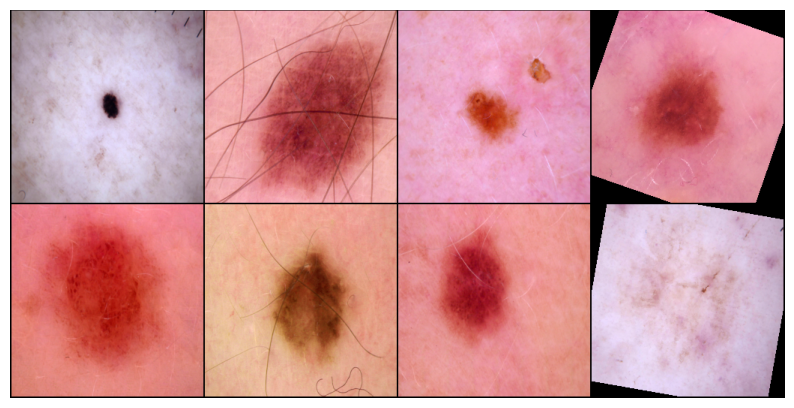

In [ ]:
#visualize
import matplotlib.pyplot as plt
import numpy as np

def visualize_batch(dataloader, num_images=8):
    batch = next(iter(dataloader))
    images = batch[:num_images]
    grid = torchvision.utils.make_grid(images, nrow=4, padding=2, normalize=True)

    grid = grid.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()


visualize_batch(train_dataloader)


In [ ]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.block = nn.Sequential(
          nn.ReLU(True),
          nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
          nn.BatchNorm2d(hidden_channels),
          nn.ReLU(True),
          nn.Conv2d(hidden_channels, in_channels, kernel_size=1, stride=1, padding=0, bias=False),
          nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class VQ(nn.Module):

  def __init__(self, num_embeddings, embedding_size, commitment_cost=0.25):
    super().__init__()
    self.num_embeddings = num_embeddings
    self.embedding_size = embedding_size
    self.commitment_cost = commitment_cost

    self.embedding = nn.Embedding(num_embeddings, embedding_size)
    self.embedding.weight.data.uniform_(-1. / num_embeddings, 1. / num_embeddings)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()  # from BCHW to BHWC
    x_flat = x.view(-1, self.embedding_size)

    w = self.embedding.weight
    distances = torch.sum(x_flat ** 2, dim=1, keepdim=True) + torch.sum(w ** 2, dim=1) - 2 * (x_flat @ w.T)
    indices_flat = torch.argmin(distances, dim=1, keepdim=True)
    quantized_flat = self.embed(indices_flat)

    quantized = quantized_flat.view(x.shape)
    indices = indices_flat.view(*x.shape[:3]).unsqueeze(dim=1)  # BHW to BCHW


    if self.training:
      e_latent_loss = F.mse_loss(quantized.detach(), x)
      q_latent_loss = F.mse_loss(quantized, x.detach())
      loss = q_latent_loss + self.commitment_cost * e_latent_loss

      quantized = x + (quantized - x).detach()
    else:
      loss = 0.

    quantized = quantized.permute(0, 3, 1, 2).contiguous()  # from BHWC to BCHW

    return quantized, indices, loss

  def embed(self, indices):
    quantized = self.embedding(indices)
    return quantized

In [ ]:
class VQVAE(nn.Module):

    def __init__(self, in_channels, num_embeddings, embedding_size=32, res_hidden_channels=32, commitment_cost=0.25):
        super().__init__()
        self.in_channels = in_channels
        self.num_embeddings = num_embeddings
        self.embedding_size = embedding_size

        h = embedding_size
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, h, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(h),
            nn.ReLU(inplace=True),
            nn.Conv2d(h, h, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(h),
            ResBlock(h, res_hidden_channels),
            ResBlock(h, res_hidden_channels),
            ResBlock(h, res_hidden_channels)
        )

        self.vq = VQ(num_embeddings, embedding_size, commitment_cost)

        self.decoder = nn.Sequential(
            ResBlock(h, res_hidden_channels),
            ResBlock(h, res_hidden_channels),
            ResBlock(h, res_hidden_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(h, h, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(h),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(h, in_channels, kernel_size=4, stride=2, padding=1)
        )

    def forward(self, x):
        z = self.encode(x)
        quantized, indices, vq_loss = self.quantize(z)
        x_recon = self.decode(quantized)
        return x_recon, quantized, indices, vq_loss

    def encode(self, x):
        z = self.encoder(x)
        return z

    def quantize(self, z):
        quantized, indices, vq_loss = self.vq(z)
        return quantized, indices, vq_loss

    def decode(self, quantized):
        x_recon = self.decoder(quantized)
        return x_recon

    def embed(self, indices):
        return self.vq.embed(indices)

In [ ]:
def generate_samples(images, model):
  with torch.no_grad():
    images = images.to(device)
    x_recon, _, _, _ = model(images)
  return x_recon

In [ ]:
model = VQVAE(3, num_embeddings).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

In [ ]:
def plot_images(data, recon_data, title):
    print("Data shape:", data.shape)
    print("Reconstructed data shape:", recon_data.shape)
    num_images = min(4, len(data))
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(15, 6))
    for i in range(num_images):
        axes[0, i].imshow(data[i].cpu().detach().numpy().transpose(1, 2, 0))
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_data[i].cpu().detach().numpy().transpose(1, 2, 0))
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.suptitle(title)
    plt.show()


In [ ]:
def compute_losses(model, data):
    image_recon, quantized, encoding_indices, vq_loss = model(data)
    recon_loss = F.mse_loss(image_recon, data)
    return recon_loss, vq_loss, image_recon

# Function for training loop
def train_epoch(model, optimizer, train_dataloader, device):
    model.train()
    recon_losses = []
    quantization_losses = []
    for i, data in enumerate(tqdm(train_dataloader)):
        data = data.to(device)
        optimizer.zero_grad()
        recon_loss, quantization_loss, image_recon = compute_losses(model, data)
        loss = recon_loss + quantization_loss
        loss.backward()
        optimizer.step()
        recon_losses.append(recon_loss.item())
        quantization_losses.append(quantization_loss.item())

        # Logging metrics to WandB
        wandb.log({"recon_loss": recon_loss.item(), "quantization_loss": quantization_loss.item()})

    plot_images(data, image_recon, title=f"Epoch: {epoch}, Batch: {i}")

    return recon_losses, quantization_losses

# WandB initialization
wandb.init(project="DL Assignment 5")

# Training loop
for epoch in range(epochs):
    recon_losses, quantization_losses = train_epoch(model, optimizer, train_dataloader, device)
    train_recon_loss = torch.tensor(recon_losses).mean()
    train_quantization_loss = torch.tensor(quantization_losses).mean()

    # Logging metrics to WandB
    wandb.log({"train_recon_loss": train_recon_loss, "train_quantization_loss": train_quantization_loss})

    # Save model after every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"vqvae_epoch_{epoch + 1}.pth")

wandb.finish()

Load VQ-VAE

In [ ]:
vqvae_model = VQVAE(3, num_embeddings).to(device)
vqvae_model.load_state_dict(torch.load('/kaggle/input/vqvae-70epochs/vqvae_epoch_70.pth'))

<All keys matched successfully>

In [ ]:
def convert_dataset(model, dataset, batch_size, device):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_indices = []
    model.eval()
    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)
            z = model.encode(x)
            quantized, indices, _ = model.quantize(z)

            all_indices.append(indices.cpu())

    indices = torch.cat(all_indices, dim=0)
    return torch.utils.data.TensorDataset(indices)

In [ ]:
z_train_dataset = convert_dataset(vqvae_model, train_dataset, batch_size=32, device=device)

Gated PixelCNN

In [ ]:
hidden_channels = 32
output_channels = 512
num_layers = 32

In [ ]:
from torch.distributions import Categorical

class GatedActivation(nn.Module):

  def __init__(self):
    super().__init__()

  def forward(self, x):
    x, y = x.chunk(2, dim=1)
    return torch.tanh(x) * torch.sigmoid(y)


class GatedMaskedConv2d(nn.Module):

    def __init__(self, mask_type, hidden_channels, kernel_size, residual):
        super().__init__()
        self.mask_type = mask_type
        self.residual = residual

        h = hidden_channels

        self.vert_stack = nn.Conv2d(
            h, h * 2, kernel_size=(kernel_size // 2 + 1, kernel_size), stride=1,
            padding=(kernel_size // 2, kernel_size // 2)
        )
        self.vert_to_horiz = nn.Conv2d(h * 2, h * 2, kernel_size=1, stride=1, padding=0)
        self.horiz_stack = nn.Conv2d(h, h * 2, kernel_size=(1, kernel_size // 2 + 1), stride=1,
                                     padding=(0, kernel_size // 2))
        self.horiz_resid = nn.Conv2d(h, h, kernel_size=1, stride=1, padding=0)

        self.gate = GatedActivation()

    def make_causal(self):
        self.vert_stack.weight.data[:, :, -1].zero_()
        self.horiz_stack.weight.data[:, :, :, -1].zero_()

    def forward(self, x_v, x_h):
        if self.mask_type == 'A':
            self.make_causal()

        h_vert = self.vert_stack(x_v)
        h_vert = h_vert[:, :, :x_v.size(-1), :]
        out_v = self.gate(h_vert)

        h_horiz = self.horiz_stack(x_h)
        h_horiz = h_horiz[:, :, :, :x_h.size(-2)]
        v2h = self.vert_to_horiz(h_vert)

        out = self.gate(v2h + h_horiz)
        if self.residual:
            out_h = self.horiz_resid(out) + x_h
        else:
            out_h = self.horiz_resid(out)

        return out_v, out_h

class GatedPixelCNN(nn.Module):

    def __init__(self, in_channels, hidden_channels, output_channels, num_layers):
        super().__init__()

        self.embedding = nn.Embedding(in_channels, hidden_channels)

        self.mask_a = GatedMaskedConv2d('A', hidden_channels, kernel_size=7,
                                        residual=False)
        self.mask_bs = nn.ModuleList([
            GatedMaskedConv2d('B', hidden_channels, kernel_size=3,
                              residual=True) for _ in range(num_layers - 1)])

        self.output_conv = nn.Sequential(
            nn.Conv2d(hidden_channels, output_channels, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, in_channels, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        x = self.embedding(x.view(-1)).view(x.shape + (-1,))
        x = x.permute(0, 3, 1, 2)

        x_v, x_h = self.mask_a(x, x)
        for mask_b in self.mask_bs:
            x_v, x_h = mask_b(x_v, x_h)

        return self.output_conv(x_h)

    def sample(self, batch_size, shape):
        device = next(self.parameters()).device
        self.eval()

        x = torch.zeros((batch_size, *shape), dtype=torch.long, device=device)

        with torch.no_grad():
            for i in range(shape[0]):
                for j in range(shape[1]):
                    logits = self.forward(x)
                    dist = Categorical(logits=logits[:, :, i, j])
                    x[:, i, j] = dist.sample()
        return x


In [ ]:
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR

in_channels = vqvae_model.num_embeddings
pixel_cnn = GatedPixelCNN(in_channels, hidden_channels, output_channels, num_layers)
pixel_cnn.to(device)

optimizer = optim.Adam(pixel_cnn.parameters(), lr=lr, weight_decay=decay)

# grad_clip_threshold = 1.3
# scheduler_step_size = 5
# scheduler_gamma = 0.1
# scheduler = StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

In [ ]:
dataloader = torch.utils.data.DataLoader(z_train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for data in dataloader:
    print(data[0].shape)
    break

torch.Size([16, 1, 64, 64])


In [ ]:
wandb.init(project="DL Assignment 5 Phase 2")

Training Loss,█▆▄▄▄▅▁▃▂▃▄▂▄▂▅▄▃▃▄▄▃▅▃▃▄▅▃▆▂▂▃▃▂▄▄▄▅▄▅▄
Training Loss,3.37756


In [ ]:
epochs = 30
train_losses = []
val_losses = []

for epoch in tqdm(range(epochs)):
    for i, indices in enumerate(dataloader):
        indices = indices[0].to(device).squeeze(dim=1)

        optimizer.zero_grad()
        out = pixel_cnn(indices)

        scores = out.permute(0, 2, 3, 1).reshape(-1, in_channels)
        loss = F.cross_entropy(scores, indices.view(-1))
        loss.backward()
        #clip_grad_norm_(pixel_cnn.parameters(), grad_clip_threshold)
        optimizer.step()
        #scheduler.step()
        train_losses.append(loss.item())
        if (epoch + 1) % 5 == 0:
            torch.save(pixel_cnn.state_dict(), f"pixel_cnn_epoch_{epoch + 1}.pth")
        wandb.log({"Training Loss": loss.item()})


100%|██████████| 30/30 [1:40:02<00:00, 200.09s/it]


In [ ]:
class PixelCNNVQVAE(nn.Module):

    def __init__(self, pixelcnn, vqvae, latent_height, latent_width):
        super().__init__()
        self.pixelcnn = pixelcnn
        self.vqvae = vqvae
        self.latent_height = latent_height
        self.latent_width = latent_width

    def sample_prior(self, batch_size, label=None):
        indices = self.pixelcnn.sample(batch_size, (self.latent_height, self.latent_width)).squeeze(dim=1)

        self.vqvae.eval()
        with torch.no_grad():
            quantized = self.vqvae.embed(indices).permute(0, 3, 1, 2)

        return quantized, indices

    def sample(self, batch_size, label=None):
        quantized, indices = self.sample_prior(batch_size)
        with torch.no_grad():
            x_recon = self.vqvae.decode(quantized)
        return x_recon, quantized, indices

In [ ]:
model_configs = [(32, 32), (64, 64), (128, 128)]
models = {}

for i, config in enumerate(model_configs):
    model_name = f"model{i+1}"
    model = PixelCNNVQVAE(pixel_cnn, vqvae_model, *config)
    models[model_name] = model


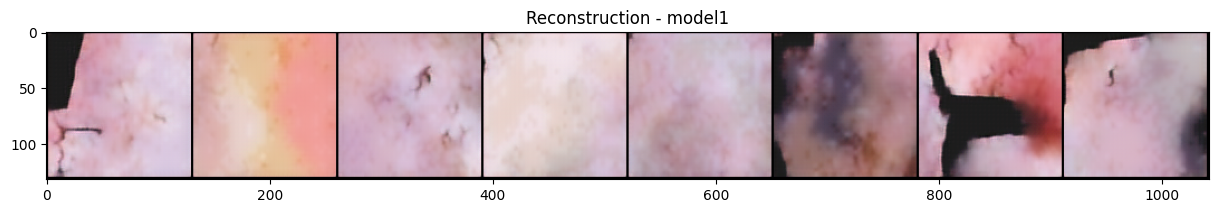

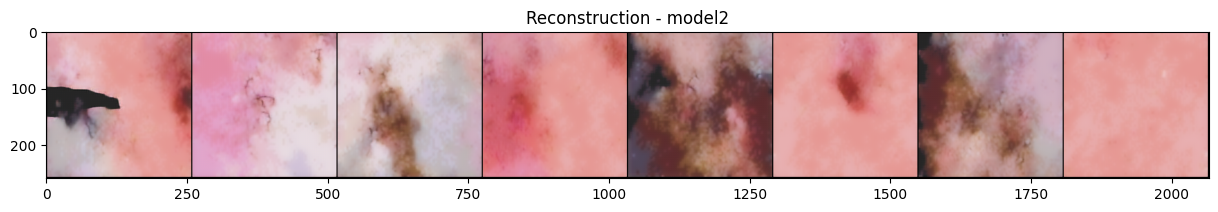

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for model_name, model in models.items():
    x_recon, quantized, indices = model.sample(8)

    grid = make_grid(x_recon.cpu(), nrow=10, normalize=True)

    fig = plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(grid, (1,2,0)), cmap="gray")
    plt.title(f"Reconstruction - {model_name}")
    plt.show()


In [ ]:
model3 = PixelCNNVQVAE(pixel_cnn, vqvae_model,128,128)
x_recon, quantized, indices = model1.sample(4)

grid = make_grid(x_recon.cpu(), nrow=10, normalize=True)

fig = plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)), cmap="gray")
plt.title("Reconstruction")
plt.show()